In [3]:
import os
os.environ["PATH"] += r"c:\Program Files\Microsoft.NET\ADOMD.NET\150"


In [7]:
from pyadomd import Pyadomd
import pandas as pd




In [9]:
import os
os.environ["PATH"] += r";C:\Program Files\Microsoft.NET\ADOMD.NET\160"

from pyadomd import Pyadomd
import pandas as pd

In [ ]:
conn_str = "Provider=MSOLAP;Data Source=localhost;Catalog=statsbomb_cube;"

mdx = """
SELECT
{
  [Measures].[Events],
  [Measures].[Passes],
  [Measures].[Carries],
  [Measures].[Pressures],
  [Measures].[Shots],
  [Measures].[Goals],
  [Measures].[Xg]
} ON COLUMNS,
[Dim Player].[Player Key].[Player Key].MEMBERS ON ROWS
FROM [Statsbomb]
"""

with Pyadomd(conn_str) as conn:
    df = pd.DataFrame(conn.cursor().execute(mdx).fetchall(),
                      columns=[col.name for col in conn.cursor().description])

print(df.head())

In [59]:
import pandas as pd
import numpy as np

df = pd.read_csv("data/shot_model.csv")
df

,event_id,match_id,team_id,player_id,is_goal,shot_x,shot_y,distance_to_goal,shot_angle,under_pressure,shot_body_part,shot_type,shot_technique,shot_first_time,shot_one_on_one,shot_statsbomb_xg
0,72596ffe-393e-4a75-82c6-5fb82ae36d4d,3754058,28,3463,0,107.1,26.6,18.600269,0.303118,f,Right Foot,Open Play,Normal,f,f,0.020838
1,b2bae775-5dd8-45bf-9b84-191c7849f707,3754058,28,3346,0,113.7,54.0,15.352199,0.225512,f,Right Foot,Open Play,Normal,f,f,0.034462
2,7c4227e5-0759-4633-93ea-bbbe291bbd72,3754058,22,3814,0,115.7,50.5,11.346365,0.296154,t,Left Foot,Open Play,Overhead Kick,t,f,0.035481
3,8e3a6f10-64e4-49bf-a157-16b15b552713,3754058,28,3346,0,113.9,38.6,6.258594,1.127515,f,Head,Open Play,Normal,f,f,0.383711
4,3a5364b3-0b99-4271-a451-0a3033ad195d,3754058,22,3671,0,96.7,47.2,24.387087,0.311593,f,Right Foot,Open Play,Half Volley,f,f,0.036740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9903,a939e4ff-a145-4712-a2ba-fb9d59fa078c,3754078,33,5594,0,112.1,38.0,8.149233,0.897504,f,Head,Open Play,Normal,f,f,0.137553
9904,43694fcd-dc3f-4351-be75-c50edcf8159e,3754078,26,3449,0,109.1,29.8,14.928161,0.398955,f,Right Foot,Open Play,Normal,f,f,0.115056
9905,dd0324cf-8325-4201-9c46-c687bebbb716,3754078,33,3621,0,114.6,51.4,12.614278,0.293148,f,Right Foot,Open Play,Normal,f,t,0.126068
9906,4a2ced59-d48c-477d-9481-45e50f28781d,3754078,33,5594,0,98.3,56.9,27.504545,0.230278,f,Right Foot,Open Play,Normal,f,f,0.023097


In [ ]:
df = df.copy()

# Convert 't'/'f' to 1/0
bool_cols = ["under_pressure", "shot_first_time", "shot_one_on_one"]
for c in bool_cols:
    df[c] = df[c].map({"t": 1, "f": 0})

# Convert target to int
df["is_goal"] = df["is_goal"].astype(int)

# Drop leakage column (we'll use it later for benchmarking)
leak_col = "shot_statsbomb_xg"

# Define feature columns (Model A: "pure xG", no player/team IDs)
numeric_features = ["shot_x", "shot_y", "distance_to_goal", "shot_angle"] + bool_cols
categorical_features = ["shot_body_part", "shot_type", "shot_technique"]

X = df[numeric_features + categorical_features].copy()
y = df["is_goal"].copy()


X

,shot_x,shot_y,distance_to_goal,shot_angle,under_pressure,shot_first_time,shot_one_on_one,shot_body_part,shot_type,shot_technique
0,107.1,26.6,18.600269,0.303118,0,0,0,Right Foot,Open Play,Normal
1,113.7,54.0,15.352199,0.225512,0,0,0,Right Foot,Open Play,Normal
2,115.7,50.5,11.346365,0.296154,1,1,0,Left Foot,Open Play,Overhead Kick
3,113.9,38.6,6.258594,1.127515,0,0,0,Head,Open Play,Normal
4,96.7,47.2,24.387087,0.311593,0,0,0,Right Foot,Open Play,Half Volley
...,...,...,...,...,...,...,...,...,...,...
9903,112.1,38.0,8.149233,0.897504,0,0,0,Head,Open Play,Normal
9904,109.1,29.8,14.928161,0.398955,0,0,0,Right Foot,Open Play,Normal
9905,114.6,51.4,12.614278,0.293148,0,0,1,Right Foot,Open Play,Normal
9906,98.3,56.9,27.504545,0.230278,0,0,0,Right Foot,Open Play,Normal


In [61]:
from sklearn.model_selection import train_test_split

# Get unique matches
matches = df["match_id"].unique()

# Split matches
train_matches, test_matches = train_test_split(
    matches,
    test_size=0.2,
    random_state=42
)

# Create train / test sets
train_idx = df["match_id"].isin(train_matches)
test_idx = df["match_id"].isin(test_matches)

X_train = X.loc[train_idx]
X_test = X.loc[test_idx]

y_train = y.loc[train_idx]
y_test = y.loc[test_idx]

print("Train shots:", X_train.shape[0])
print("Test shots:", X_test.shape[0])
print("Train goal rate:", y_train.mean())
print("Test goal rate:", y_test.mean())


Train shots: 7909
Test shots: 1999
Train goal rate: 0.10102414970287014
Test goal rate: 0.0945472736368184


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

# Preprocessing
numeric_transformer = Pipeline(
    steps=[
        ("scaler", StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss, brier_score_loss

# Logistic Regression model
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",  # important because goals are rare
    solver="lbfgs"
)

# Full pipeline
log_reg_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", log_reg),
    ]
)

# Train
log_reg_pipeline.fit(X_train, y_train)

# Predict probabilities
y_pred_proba = log_reg_pipeline.predict_proba(X_test)[:, 1]

# Evaluation
roc = roc_auc_score(y_test, y_pred_proba)
ll = log_loss(y_test, y_pred_proba)
brier = brier_score_loss(y_test, y_pred_proba)

print(f"Logistic Regression ROC-AUC: {roc:.3f}")
print(f"Logistic Regression Log Loss: {ll:.3f}")
print(f"Logistic Regression Brier: {brier:.3f}")


Logistic Regression ROC-AUC: 0.800
Logistic Regression Log Loss: 0.557
Logistic Regression Brier: 0.186


In [64]:
# Get feature names after preprocessing
feature_names = (
    numeric_features +
    list(
        log_reg_pipeline
        .named_steps["preprocessor"]
        .named_transformers_["cat"]
        .named_steps["onehot"]
        .get_feature_names_out(categorical_features)
    )
)

# Extract coefficients
coefs = (
    log_reg_pipeline
    .named_steps["model"]
    .coef_[0]
)

coef_df = (
    pd.DataFrame({
        "feature": feature_names,
        "coefficient": coefs
    })
    .sort_values("coefficient", ascending=False)
)

display(coef_df.head(15))
display(coef_df.tail(15))


,feature,coefficient
11,shot_type_Corner,2.020474
16,shot_technique_Diving Header,1.587629
18,shot_technique_Lob,1.379139
9,shot_body_part_Other,0.968730
14,shot_type_Penalty,0.902133
10,shot_body_part_Right Foot,0.356644
3,shot_angle,0.298993
8,shot_body_part_Left Foot,0.292007
19,shot_technique_Normal,0.242686
6,shot_one_on_one,0.178521


,feature,coefficient
8,shot_body_part_Left Foot,0.292007
19,shot_technique_Normal,0.242686
6,shot_one_on_one,0.178521
5,shot_first_time,0.098615
4,under_pressure,-0.079729
1,shot_y,-0.080299
0,shot_x,-0.327328
17,shot_technique_Half Volley,-0.342353
15,shot_technique_Backheel,-0.364254
12,shot_type_Free Kick,-0.653901


In [ ]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
)
xgb_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", xgb_model),
    ]
)

# Train
xgb_pipeline.fit(X_train, y_train)

# Predict
y_pred_proba_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]

# Evaluate
roc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
ll_xgb = log_loss(y_test, y_pred_proba_xgb)
brier_xgb = brier_score_loss(y_test, y_pred_proba_xgb)

print(f"XGBoost ROC-AUC: {roc_xgb:.3f}")
print(f"XGBoost Log Loss: {ll_xgb:.3f}")
print(f"XGBoost Brier: {brier_xgb:.3f}")


XGBoost ROC-AUC: 0.796
XGBoost Log Loss: 0.257
XGBoost Brier: 0.073


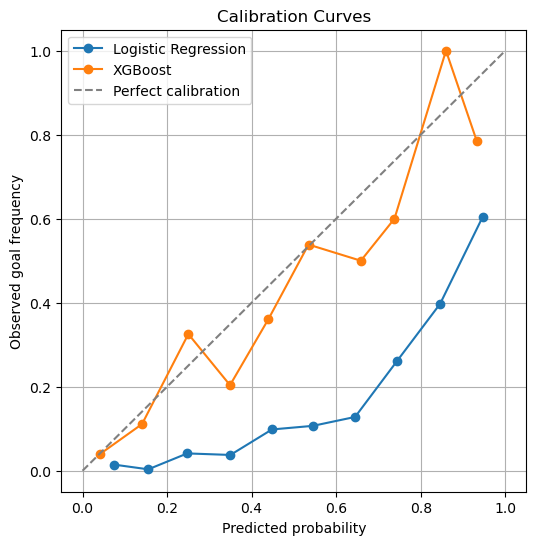

In [ ]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Calibration curves
prob_true_lr, prob_pred_lr = calibration_curve(
    y_test, y_pred_proba, n_bins=10
)

prob_true_xgb, prob_pred_xgb = calibration_curve(
    y_test, y_pred_proba_xgb, n_bins=10
)

plt.figure(figsize=(6, 6))
plt.plot(prob_pred_lr, prob_true_lr, marker="o", label="Logistic Regression")
plt.plot(prob_pred_xgb, prob_true_xgb, marker="o", label="XGBoost")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfect calibration")

plt.xlabel("Predicted probability")
plt.ylabel("Observed goal frequency")
plt.title("Calibration Curves")
plt.legend()
plt.grid(True)
plt.show()

In [67]:
# StatsBomb xG comparison
sb_xg = df.loc[test_idx, "shot_statsbomb_xg"]

roc_sb = roc_auc_score(y_test, sb_xg)
ll_sb = log_loss(y_test, sb_xg)
brier_sb = brier_score_loss(y_test, sb_xg)

print(f"StatsBomb xG ROC-AUC: {roc_sb:.3f}")
print(f"StatsBomb xG Log Loss: {ll_sb:.3f}")
print(f"StatsBomb xG Brier: {brier_sb:.3f}")


StatsBomb xG ROC-AUC: 0.826
StatsBomb xG Log Loss: 0.241
StatsBomb xG Brier: 0.068


In [68]:
# Add predictions back to dataframe
df.loc[test_idx, "xg_xgb"] = y_pred_proba_xgb
df.loc[test_idx, "goal"] = y_test.values

team_xg = (
    df.loc[test_idx]
    .groupby("team_id")
    .agg(
        goals=("goal", "sum"),
        xg=("xg_xgb", "sum")
    )
    .sort_values("xg", ascending=False)
)

team_xg


,goals,xg
team_id,,
22,17.0,20.306265
38,13.0,16.515053
33,15.0,16.261848
29,16.0,13.947856
1,11.0,13.770449
36,19.0,13.462749
40,13.0,11.590450
24,6.0,11.239942
39,3.0,10.179278
